# NAMM Evaluation
This notebook shows how to load a pretrained NAMM, MDM, and vanilla DM for a given constraint. Although the finetuned NAMM is used, finetuning is often not necessary as it only provides marginal improvements. It compares MDM and DM samples visually and in terms of constraint distance.

## Setup

In [1]:
import os
import sys
import time
sys.path.append('..')

import flax
from flax.training import checkpoints
import jax
import matplotlib.pyplot as plt
import orbax.checkpoint as ocp
import seaborn as sns

from losses import get_constraint_losses_fn
import model_utils as namm_mutils
from pdes import get_vorticity_image_fn

from score_flow import losses as score_losses
from score_flow import sampling
from score_flow import utils
from score_flow.models import utils as score_mutils
from score_flow.models import ddpm, ncsnpp, ncsnv2

from configs import namm_config as namm_config_provider
from configs import score_config as score_config_provider

sns.set(font_scale=2)
sns.set_style('ticks')
palette = sns.color_palette('colorblind')

2025-02-07 14:39:04.914247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738967944.927258  378658 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738967944.931460  378658 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# The following settings are the ones used in the paper.

DATASET_PER_CONSTRAINT = {
  'flux': 'GRMHD',
  'burgers': 'Burgers',
  'periodic': 'Periodic',
  'incompress': 'Kolmogorov',
  'count': 'Galaxies',
}

IMAGE_SHAPE_PER_CONSTRAINT = {
  'flux': (64, 64, 1),
  'burgers': (64, 64, 1),
  'periodic': (64, 64, 1),
  'incompress': (128, 256, 2),
  'count': (128, 128, 1),
}

CMAP_PER_CONSTRAINT = {
  'flux': 'afmhot',
  'burgers': 'viridis',
  'periodic': 'gray',
  'incompress': sns.cm.icefire,
  'count': 'magma'
}

WORKDIR_PER_CONSTRAINT = {
  'flux': '../checkpoints/GRMHD_flux/sparseicnn_cyc=1.0_reg=0.001_constr=0.01_maxsig=0.1_lr=2e-04_bs=16_layers=3_fwdnfilt=32_bwdnfilt=64',
  'burgers': '../checkpoints/Burgers_burgers/sparseicnn_cyc=1.0_reg=0.001_constr=1.0_maxsig=0.1_lr=2e-04_bs=16_layers=3_fwdnfilt=32_bwdnfilt=64',
  'periodic': '../checkpoints/Periodic_periodic/sparseicnn_cyc=1.0_reg=0.001_constr=1.0_maxsig=0.1_lr=2e-04_bs=16_layers=3_fwdnfilt=32_bwdnfilt=64',
  'incompress': '../checkpoints/Kolmogorov_incompress/sparseicnn_cyc=1.0_reg=0.001_constr=1.0_maxsig=0.5_lr=1e-03_bs=16_layers=2_fwdnfilt=32_bwdnfilt=64_nores',
  'count': '../checkpoints/Galaxies_count/sparseicnn_cyc=1.0_reg=0.001_constr=0.01_maxsig=0.1_lr=2e-04_bs=16_layers=2_fwdnfilt=32_bwdnfilt=64_nores'
}

DM_WORKDIR_PER_CONSTRAINT = {
  'flux': '../score_checkpoints/GRMHD_64x64_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0',
  'burgers': '../score_checkpoints/Burgers_64x64_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0',
  'periodic': '../score_checkpoints/Periodic_64x64_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0',
  'incompress': '../score_checkpoints/Kolmogorov_128x256_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0',
  'count': '../score_checkpoints/Galaxies_128x128_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0'
}

NAMM_EPOCH_PER_CONSTRAINT = {
  'flux': 30,
  'burgers': 100,
  'periodic': 50,
  'incompress': 100,
  'count': 50,
}

NAMM_FT_EPOCH_PER_CONSTRAINT = {
  'flux': 1000,
  'burgers': 700,
  'periodic': 1000,
  'incompress': 500,
  'count': 700,
}

MDM_EPOCH_PER_CONSTRAINT = {
  'flux': 200,
  'burgers': 300,
  'periodic': 300,
  'incompress': 700,
  'count': 300,
}

DM_EPOCH_PER_CONSTRAINT = {
  'flux': 450,
  'burgers': 1500,
  'periodic': 1000,
  'incompress': 2000,
  'count': 1500,
}

In [3]:
# Set the desired constraint and number of samples.

constraint = 'burgers'  # 'flux' | 'burgers' | 'incompress' | 'periodic' | 'count'
n_samp = 128  # number of samples to generate from MDM and DM
# The checkpoints of the models used for the paper were saved with legacy Flax checkpointing.
use_orbax_checkpointing = False  # whether to use Orbax checkpointing (True) or legacy Flax checkpointing (False)

## Sample from MDM

In [4]:
workdir = WORKDIR_PER_CONSTRAINT[constraint]
image_shape = IMAGE_SHAPE_PER_CONSTRAINT[constraint]
dataset = DATASET_PER_CONSTRAINT[constraint]
cmap = CMAP_PER_CONSTRAINT[constraint]

# Get NAMM config.
namm_config = namm_config_provider.get_config()
namm_config.data.dataset = dataset
namm_config.data.height = image_shape[0]
namm_config.data.width = image_shape[1]
namm_config.data.num_channels = image_shape[2]
namm_config.constraint.type = constraint
# Default settings:
namm_config.model.bwd_activation = 'softplus'
namm_config.model.fwd_icnn_n_layers = 3
namm_config.model.fwd_residual = True
namm_config.model.bwd_residual = True
namm_config.data.constant_flux = False
# Special settings:
if constraint == 'flux':
  namm_config.data.constant_flux = True
if dataset == 'Kolmogorov':
  namm_config.model.bwd_activation = 'none'
  namm_config.model.bwd_residual = False
  namm_config.model.fwd_icnn_n_layers = 2
if constraint == 'count':
  namm_config.constraint.counting_cnn_ckpt_path = os.path.join(os.getcwd(), '../checkpoints/counting_cnn')
  namm_config.model.bwd_residual = False
  namm_config.model.fwd_icnn_n_layers = 2

# Load NAMM checkpoint.
namm_model = namm_mutils.get_model(namm_config)
namm_state = namm_mutils.init_state(namm_config, namm_model)
namm_state, _, _ = namm_mutils.init_optimizer(namm_config, namm_state)

namm_epoch = NAMM_FT_EPOCH_PER_CONSTRAINT[constraint]
namm_ckpt_path = os.path.join(os.getcwd(), workdir, f'finetune/namm/checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(namm_ckpt_path)
  namm_state = ckpt_mgr.restore(namm_epoch, args=ocp.args.StandardRestore(namm_state))
else:
  namm_state = checkpoints.restore_checkpoint(
    os.path.join(namm_ckpt_path, f'checkpoint_{namm_epoch}'),
    namm_state)
assert namm_state.epoch == namm_epoch
print('NAMM epoch:', namm_state.epoch)

# Define learned inverse mirror map.
def inverse_mirror_fn(x):
  return namm_model.backward(
    {'dropout': jax.random.PRNGKey(0)}, namm_state.bwd_params, x, train=False)

NAMM epoch: 700


In [5]:
# Get score-model config.
score_config = score_config_provider.get_config()
score_config.data = namm_config.data

# Create score model and state.
# These will be used for sampling with the MDM and the DM.
score_model, score_init_model_state, score_init_params = score_mutils.init_model(
  jax.random.PRNGKey(0), score_config)
score_tx = score_losses.get_optimizer(score_config)
score_opt_state = score_tx.init(score_init_params)
score_state = score_mutils.State(
  step=0,
  epoch=0,
  model_state=score_init_model_state,
  opt_state=score_opt_state,
  ema_rate=score_config.model.ema_rate,
  params=score_init_params,
  params_ema=score_init_params,
  rng=jax.random.PRNGKey(0))
sde, t0 = utils.get_sde(score_config)
sampling_shape = (n_samp // jax.local_device_count(), *image_shape)
sampling_fn = sampling.get_sampling_fn(
    score_config, sde, score_model, sampling_shape, inverse_scaler=lambda x: x, eps=t0)

# Load MDM checkpoint.
mdm_epoch = MDM_EPOCH_PER_CONSTRAINT[constraint]
mdm_ckpt_path = os.path.join(os.getcwd(), workdir, f'mdm/checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(mdm_ckpt_path)
  score_state = ckpt_mgr.restore(mdm_epoch, args=ocp.args.StandardRestore(score_state))
else:
  score_state = checkpoints.restore_checkpoint(
    os.path.join(mdm_ckpt_path, f'checkpoint_{mdm_epoch}'),
    score_state)
assert score_state.epoch == mdm_epoch
print('MDM epoch:', score_state.epoch)

score_pstate = flax.jax_utils.replicate(score_state)

MDM epoch: 300


In [6]:
# Sample mirror samples from MDM.
sample_rng = jax.random.PRNGKey(100)
_, sample_rngs = utils.psplit(sample_rng)

s = time.perf_counter()
print(f'Sampling from MDM (epoch {score_state.epoch})...', end=' ', flush=True)
y_samples, _ = sampling_fn(sample_rngs, score_pstate)
y_samples = y_samples.reshape(-1, *image_shape)
print(f'done ({time.perf_counter() - s:.2f}s)!', flush=True)

# Apply inverse mirror map to MDM samples.
samples = inverse_mirror_fn(y_samples)

# For Kolmogorov data, we need to convert to a vorticity image.
if dataset == 'Kolmogorov':
  image_y_samples = get_vorticity_image_fn(vmap=True)(y_samples)
  image_samples = get_vorticity_image_fn(vmap=True)(samples)
else:
  image_y_samples = y_samples
  image_samples = samples

Sampling from MDM (epoch 300)... done (36.16s)!


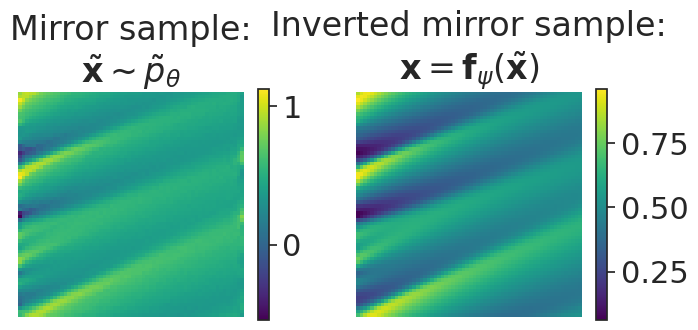

In [7]:
# Show mirror sample vs. inverted mirror sample.
figsize = (15, 3) if dataset == 'Kolmogorov' else (8, 3)
plt.figure(figsize=figsize)
plt.subplot(121)
plt.imshow(image_y_samples[0], cmap=cmap)
plt.axis('off')
plt.colorbar()
plt.title('Mirror sample:\n' + r'$\tilde{\mathbf{x}}\sim \tilde{p}_\theta$')
plt.subplot(122)
plt.imshow(image_samples[0], cmap=cmap)
plt.axis('off')
plt.colorbar()
plt.title('Inverted mirror sample:\n' + r'$\mathbf{x}=\mathbf{f}_\psi(\tilde{\mathbf{x}})$')
plt.show()

## Sample from DM

In [8]:
# Restore DM checkpoint.
dm_epoch = DM_EPOCH_PER_CONSTRAINT[constraint]
dm_workdir = DM_WORKDIR_PER_CONSTRAINT[constraint]
dm_ckpt_path = os.path.join(os.getcwd(), dm_workdir, 'checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(dm_ckpt_path)
  dm_score_state = ckpt_mgr.restore(dm_epoch, args=ocp.args.StandardRestore(score_state))
else:
  dm_score_state = checkpoints.restore_checkpoint(
    os.path.join(dm_ckpt_path, f'checkpoint_{dm_epoch}'),
    score_state)
assert dm_score_state.epoch == dm_epoch
print('DM epoch:', dm_score_state.epoch)

dm_score_pstate = flax.jax_utils.replicate(dm_score_state)

# Sample from DM.
s = time.perf_counter()
print(f'Sampling from DM epoch {dm_score_state.epoch}...', end=' ', flush=True)
dm_samples, _ = sampling_fn(sample_rngs, dm_score_pstate)
dm_samples = dm_samples.reshape(-1, *image_shape)
print(f'done ({time.perf_counter() - s:.2f}s)!', flush=True)

if dataset == 'Kolmogorov':
  dm_image_samples = get_vorticity_image_fn(vmap=True)(dm_samples)
else:
  dm_image_samples = dm_samples

DM epoch: 1500
Sampling from DM epoch 1500... done (21.20s)!


## Compare samples

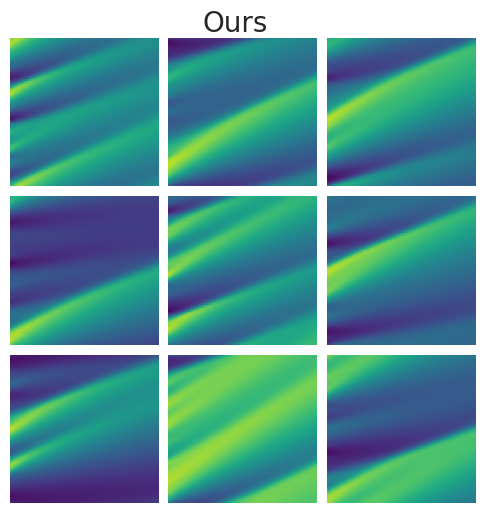

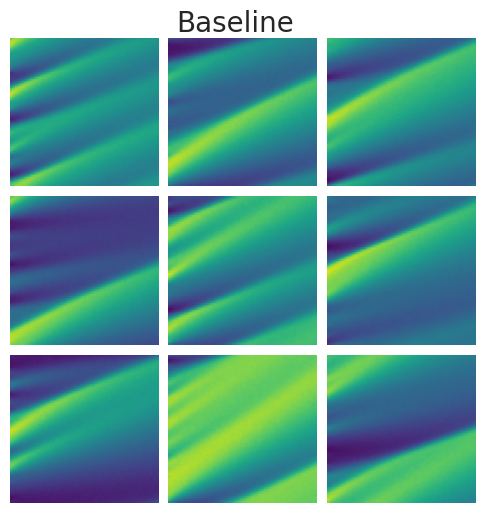

In [9]:
figsize = (6, 3.5) if dataset == 'Kolmogorov' else (6, 6)
clim = (min(image_samples.min(), dm_image_samples.min()), 
        max(image_samples.max(), dm_image_samples.max()))
utils.plot_image_grid(image_samples[:9], figsize=figsize, cmap=cmap, normalize=clim, title='Ours');
utils.plot_image_grid(dm_image_samples[:9], figsize=figsize, cmap=cmap, normalize=clim, title='Baseline');

## Evaluate constraint satisfaction

In [10]:
constr_losses_fn = get_constraint_losses_fn(namm_config)
constr_losses = constr_losses_fn(samples)
dm_constr_losses = constr_losses_fn(dm_samples)

# Normalize constraint distances.
max_constr_loss = max(constr_losses.max(), dm_constr_losses.max())
norm_constr_losses = constr_losses / max_constr_loss
norm_dm_constr_losses = dm_constr_losses / max_constr_loss

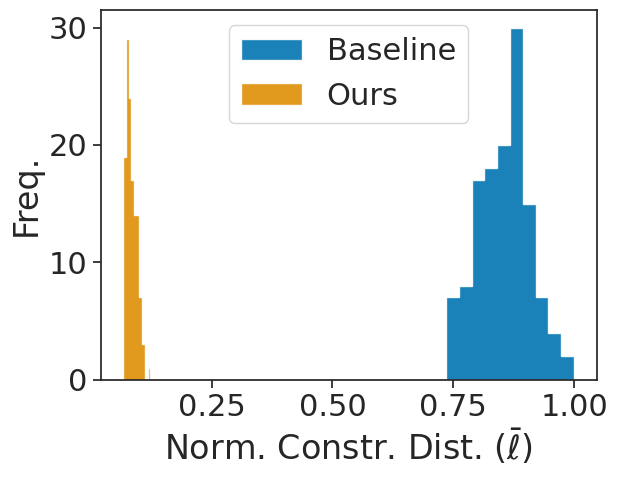

In [11]:
plt.hist(norm_dm_constr_losses, histtype='stepfilled', color=palette[0], alpha=0.9, label='Baseline')
plt.hist(norm_constr_losses, histtype='stepfilled', color=palette[1], alpha=0.9, label='Ours')
plt.legend()
plt.xlabel(r'Norm. Constr. Dist. ($\bar{\ell}$)')
plt.ylabel('Freq.')
plt.show()